## <center> **Livrable n°2 : Traitement d'images** </center>

‎ 

Réalisé par le **groupe n°2** :
- BERTHO Lucien
- BOSACKI Paul
- GAURE Warren
- GRENOUILLET Théo
- VALLEMONT Hugo


‎

---


### **Sommaire**

1. [Mise en contexte](#contexte)
2. [Objectif du livrable](#objectif)
3. [Importation des bibliothèques](#import)
4. [Prétraitement et exploration des données](#gestion)
5. [Item #5](#item5)
6. [Item #6](#item6)
7. [Item #7](#item7)
8. [Item #8](#item8)
9. [Item #9](#item9)
10. [Item #10](#item10)

‎ 

---

### 1. <a id='contexte'>Mise en contexte</a>

L’entreprise TouNum est spécialisée dans la numérisation de documents, qu’il s’agisse de textes ou d’images. Ses services sont particulièrement sollicités par des entreprises cherchant à transformer leur base documentaire papier en fichiers numériques exploitables. Aujourd’hui, TouNum souhaite aller plus loin en enrichissant son offre avec des outils basés sur le Machine Learning.

En effet, certains clients disposent d’un volume considérable de documents à numériser et expriment un besoin croissant pour des solutions de catégorisation automatique. Une telle innovation leur permettrait d’optimiser le traitement et l’exploitation de leurs données numérisées. Toutefois, TouNum ne dispose pas en interne des compétences nécessaires pour concevoir et mettre en place ces technologies.

C’est dans ce cadre que notre équipe de spécialistes en Data Science du CESI est sollicitée. Notre mission consiste à développer une première solution intégrant du captioning automatique : un système capable d’analyser des photographies et de générer une légende descriptive de manière autonome.

Heureusement, TouNum possède déjà plusieurs milliers d’images annotées, ce qui constituera une ressource précieuse pour entraîner les modèles de Machine Learning à partir d’un apprentissage supervisé.

---

### 2. <a id='objectif'>Objectif du livrable</a>

Pour cette seconde étape du workflow, il est demandé de traiter les images qui seront destinées à être annotées. Ce livrable propose une méthode de traitement basée sur les auto-encodeurs à convolution afin de débruiter les images fournies et de pouvoir les reconstituer.

---

### 3. <a id='import'>Importation des bibliothèques</a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

---

### 4. <a id='gestion'>Prétraitement et exploration des données</a>

Une fois les bibliothèques importées, nous pouvons désormais gérer les données qui nous ont été données.

#### 4.1. <a>Vérification des images</a>

À l'instar de la première étape du workflow, nous vérifions le bon état des images.

In [5]:
dataset_directory = "dataset_livrable_2/"

In [6]:
def is_valid_image(path):
    try:
        img_raw = tf.io.read_file(path)
        _ = tf.image.decode_image(img_raw, channels=3)
        return (path, True)
    except Exception:
        return (path, False)

def clean_corrupted_images(directory, extensions=("jpg", "jpeg", "png"), max_workers=8):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(extensions):
                image_paths.append(os.path.join(root, file))

    print(f"Scan de {len(image_paths)} images dans {directory}")

    corrupted_count = 0
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(is_valid_image, path) for path in image_paths]
        for future in as_completed(futures):
            path, is_valid = future.result()
            if not is_valid:
                try:
                    os.remove(path)
                    corrupted_count += 1
                except Exception as e:
                    print(f"Erreur de suppression {path} : {e}")

    print(f"Vérification terminée : {corrupted_count} image(s) corrompue(s) supprimée(s).")
    

clean_corrupted_images(dataset_directory)

Scan de 148 images dans dataset_livrable_2/
Vérification terminée : 0 image(s) corrompue(s) supprimée(s).


Il s'avérait qu'aucune image a été corrompue.

──────────────────────────────────────────────────

#### 4.2. <a>Chargement des données</a>

Après vérification, nous pouvons charger les données.

In [ ]:
image_h = 128
image_w = 128
batch_s = 16

dataset = keras.utils.image_dataset_from_directory(
    directory = dataset_directory,
    label_mode = None,
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = 42
)

Found 148 files.


La sortie indique la présence de **148** images en tout, ce qui rendra le traitement de ces dernières plus rapide que durant l'étape précédente !

──────────────────────────────────────────────────

#### 4.3. <a>Prétraitement des données</a>

Étant donné que nous travaillons à nouveau avec des images, c'est-à-dire des ensembles de pixels dont les valeurs sont comprises entre 0 et 255, nous devons les mettre à dans l'intervalle `[0, 1]` afin de mieux les traiter.

In [26]:
dataset = dataset.map(lambda x: tf.cast(x, tf.float32) / 255.0)

X = []

for batch in dataset:
    X.append(batch.numpy())
    
dataset = np.concatenate(X)
print(dataset.shape)


(148, 128, 128, 3)


──────────────────────────────────────────────────

#### 4.4. <a>Affichage des images</a>

Maintenant que le prétraitement est fait, nous pouvons afficher des images grâce à une fonction.

In [43]:
def display_images():
    plt.figure(figsize=(8, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(dataset[i])
        plt.axis("off")
    plt.show()

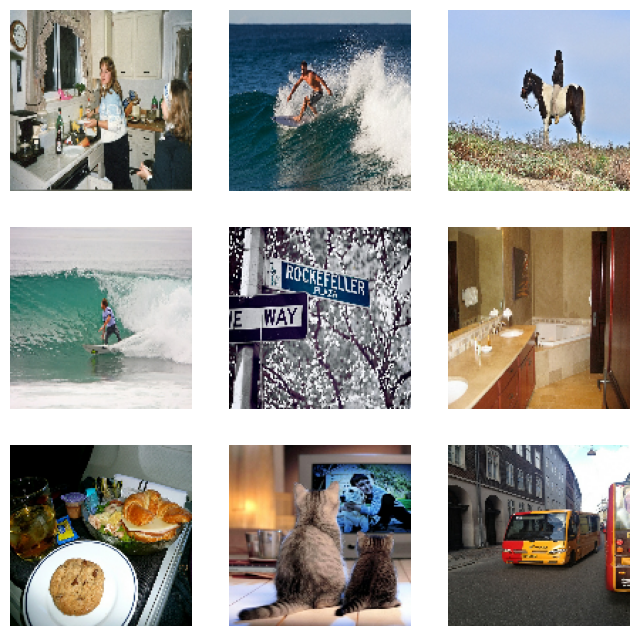

In [44]:
display_images()

---